In [46]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split





In [47]:
sales_data = pd.read_csv("Assignment4.1a.csv")
promotion_data = pd.read_csv("Promotiondates.csv")

sales_data['Date'] = pd.to_datetime(sales_data['Date'])
promotion_data['StartDate'] = pd.to_datetime(promotion_data['StartDate'])
promotion_data['EndDate'] = pd.to_datetime(promotion_data['EndDate'])

/var/folders/mg/nyj1pb9152v8v1f7lgfx68y80000gn/T/ipykernel_19147/4072033385.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  promotion_data['StartDate'] = pd.to_datetime(promotion_data['StartDate'])
/var/folders/mg/nyj1pb9152v8v1f7lgfx68y80000gn/T/ipykernel_19147/4072033385.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  promotion_data['EndDate'] = pd.to_datetime(promotion_data['EndDate'])


# Data Expolaration

First, lest check the data itself.

In [48]:
sales_data.head()

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-01-01,8,9,-1
1,2015-01-01,131,9,1
2,2015-01-01,144,9,2
3,2015-01-01,203,9,2
4,2015-01-01,256,9,0


In [49]:
promotion_data

,Period,StartDate,EndDate
0,Promo1,2015-02-10,2015-02-17
1,Promo2,2015-03-15,2015-03-22
2,Promo3,2015-05-24,2015-06-01
3,Promo4,2015-06-21,2015-06-28
4,Promo5,2015-01-09,2015-06-09
5,Promo6,2015-11-20,2015-11-27


We will use only first 4 promotions. Lets also check how total sale per day looks like with promotions dates labeled.

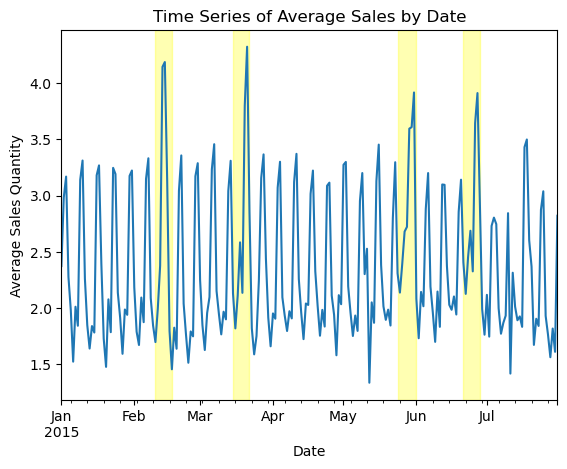

In [50]:
sales_data.groupby('Date')['SalesQuantity'].mean().plot()

for index, row in promotion_data[:4].iterrows():
    plt.axvspan(row['StartDate'], row['EndDate'], alpha=0.3, color='yellow')

plt.xlabel('Date')
plt.ylabel('Average Sales Quantity')
plt.title('Time Series of Average Sales by Date')
plt.show()


The plot shows the average sales quantity over time, where the x-axis represents the date, and the y-axis represents the average sales quantity. The yellow shaded regions indicate the promotion dates. The plot helps us visualize the impact of promotions on sales. We can see if there are any noticeable spikes or changes in sales during the promotion periods. From the plot, we can observe that there is a weekly pattern of weakly seasons. However, no effect of year-wide seasonal variability is observable. Finally, there are distinct spikes in promotion periods. We will use these breakdowns for feature engineering.

# Developing the Model

It is possible to design different models for different feature and label choices. For example, it is possible to construct features and use them to predict sales per store and product combinations. However, this multi-label setting can create a very high-dimensional label, which can be problematic if these labels are sparse, as is the case for us. So instead, we will use product and shop IDs as features and try to predict the number of sales for given IDs.

## Feature Engineering

As explained above, we will attempt to predict sales for specific item and store IDs. Additionally, we will incorporate some time-dependent features. Since our data spans a single year, features with an annual period are not useful. However, there is clear weekly seasonality, making the day of the week a crucial feature. While monthly seasonality is less apparent, it's reasonable to assume that people may purchase more products when they receive their salaries. Rather than using the day of the month, which can lead to sparse data when grouped, we opt for the week of the month using a custom implementation. Lastly, we include a binary feature indicating whether there is a promotion.

The summary of all features is as follows:

- DayOfWeek: Represents the day of the week (0-6).
- WeekInMonth: Represents the week number in a month (0-3).
- Promotion: Represents whether there is a promotion or not (True/False).
- StoreCode: Represents the code of the store.
- ProductCode: Represents the code of the product.

These features are utilized to predict the sales quantity for given item and store IDs. The `prepare_data` method also includes a flag to one-hot-encode the features if necessary for certain models.


In [51]:
def weekinmonth(dates):
    """Get week number in a month.
    
    Parameters: 
        dates (pd.Series): Series of dates.
    Returns: 
        pd.Series: Week number in a month.
    """
    firstday_in_month = dates - pd.to_timedelta(dates.dt.day - 1, unit='d')
    return (dates.dt.day-1 + firstday_in_month.dt.weekday) // 7 + 1

In [52]:
def prepare_data(sales_data, promotion_data, dummy=False):
    processed = sales_data.copy(deep = True)
    processed['DayOfWeek'] = processed['Date'].dt.dayofweek
    processed['WeekInMonth'] = weekinmonth(processed['Date']) - 1
    processed['Promotion'] = False
    for index, row in promotion_data.iterrows():
        processed.loc[(processed['Date'] >= row['StartDate']) & (processed['Date'] <= row['EndDate']), 'Promotion'] = True
    processed = processed.groupby(['DayOfWeek',"WeekInMonth",'Promotion', 'StoreCode', 'ProductCode'])['SalesQuantity'].mean().reset_index()
    if dummy:
        ohe_processed = pd.get_dummies(processed, columns=['DayOfWeek',"WeekInMonth",'Promotion', 'StoreCode', 'ProductCode'])
    else:
        ohe_processed = processed
    features = ohe_processed.drop('SalesQuantity', axis=1)
    target = ohe_processed['SalesQuantity']

    return features, target



## Selecting and Training the Model

The code below essentially compares the performance of three regression models: linear regression, random forest, and gradient boosting, on the given data. It aims to determine which model performs better in terms of predicting the target variable (y) based on the features (X).

The code starts by preparing the data using the `prepare_data` function, formatting it appropriately for regression analysis. It then splits the data into training and validation sets using the `train_test_split` function. The validation set comprises 20% of the total data, and a random state of 42 is set for reproducibility.

We train three different models: Linear Regression, Random Forest, and Gradient Boosting. Each method has its model bias with pros and cons. It's important to note that data is one-hot-encoded only for Linear Regression. This is due to the fact that tree-based models can inherently overcome this issue, and one-hot-encoding can even result in worse performance.

After training the models, we make predictions on the validation set and calculate the mean squared error (MSE) for each model on both the validation and training sets.


In [53]:

X, y = prepare_data(sales_data, promotion_data, True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Linear Regresion is training ...")
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_reg_pred = linear_reg.predict(X_val)
linear_reg_mse = mean_squared_error(y_val, linear_reg_pred)
linear_reg_train_pred = linear_reg.predict(X_train)
linear_reg_train_mse = mean_squared_error(y_train, linear_reg_train_pred)

X, y = prepare_data(sales_data, promotion_data)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Random Forest is training ...")
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
rf_reg_pred = rf_reg.predict(X_val)
rf_reg_mse = mean_squared_error(y_val, rf_reg_pred)
rf_reg_train_pred = rf_reg.predict(X_train)
rf_reg_train_mse = mean_squared_error(y_train, rf_reg_train_pred)

print("Gradient Boosting is training ...")
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train, y_train)
gb_reg_pred = gb_reg.predict(X_val)
gb_reg_mse = mean_squared_error(y_val, gb_reg_pred)
gb_reg_train_pred = gb_reg.predict(X_train)
gb_reg_train_mse = mean_squared_error(y_train, gb_reg_train_pred)

print("Linear Regression Validation MSE:", linear_reg_mse)
print("Linear Regression Training MSE:", linear_reg_train_mse)
print("Random Forest Validation MSE:", rf_reg_mse)
print("Random Forest Training MSE:", rf_reg_train_mse)
print("Gradient Boosting Validation MSE:", gb_reg_mse)
print("Gradient Boosting Training MSE:", gb_reg_train_mse)



Linear Regresion is training ...
Random Forest is training ...
Gradient Boosting is training ...
Linear Regression Validation MSE: 9.192832607734537e+20
Linear Regression Training MSE: 12.721734271250691
Random Forest Validation MSE: 14.240496803284747
Random Forest Training MSE: 1.910609503899528
Gradient Boosting Validation MSE: 13.647557651759518
Gradient Boosting Training MSE: 13.084809674077446


Linear Regression is clearly the worst performing model, while tree based method achieved better results. While it looks like Gradient Boosting have the best validation MSE, it only outputs the averages, so we will use Random Forest as our final methods since its validation-training values seems more balanced. 

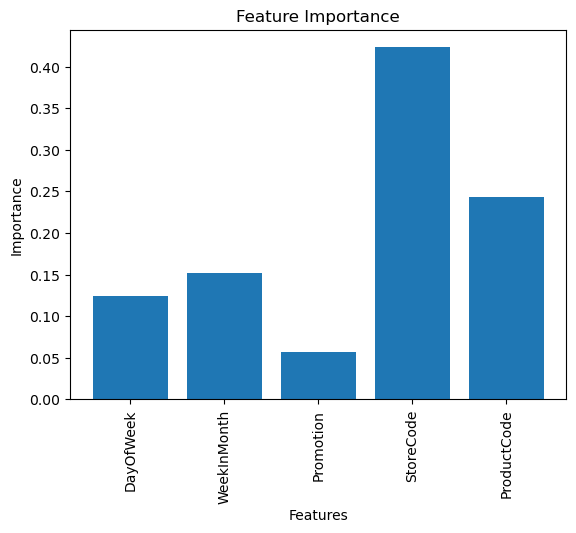

In [54]:
importance = rf_reg.feature_importances_
features = X_train.columns

plt.bar(features, importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

In [55]:
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X, y)
regressor_pred = gb_reg.predict(X)
mse = mean_squared_error(y,regressor_pred)
print("Final Regressor Training MSE:", mse)

Final Regressor Training MSE: 13.197359355611052


# Data Analytics

# a & b.

To separate items, I plotted the products and sales quantities and selected appropriate quantile values such that fast and slow items are significantly separable from the medium. I used the same methodology for items and stores. The final chosen thresholds are a result of this trial and error process.


In [56]:
sales_data_promotion = sales_data.assign(Promotion = np.logical_or.reduce([sales_data['Date'].between(s, e) for s, e in zip(promotion_data['StartDate'][0:4], promotion_data['EndDate'][0:4])]))
average_sales_per_store = sales_data_promotion[~sales_data_promotion["Promotion"]].groupby(['StoreCode'])['SalesQuantity'].mean().reset_index()
average_sales_per_product = sales_data_promotion[~sales_data_promotion["Promotion"]].groupby(['ProductCode'])['SalesQuantity'].mean().reset_index()


product_clusters = pd.qcut(average_sales_per_product['SalesQuantity'], q=[0,0.05,0.80,1], labels=['Slow items', 'Medium items', 'Fast items'])

store_clusters = pd.qcut(average_sales_per_store['SalesQuantity'], q=[0,0.10,0.85,1], labels=['Slow stores', 'Medium stores', 'Fast stores'])

average_sales_per_product['Cluster'] = product_clusters
average_sales_per_store['Cluster'] = store_clusters




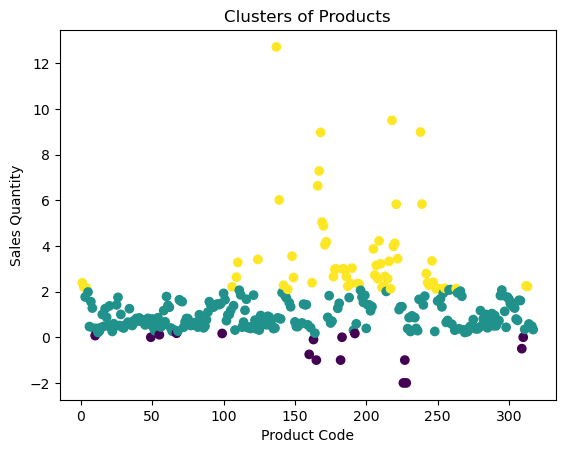

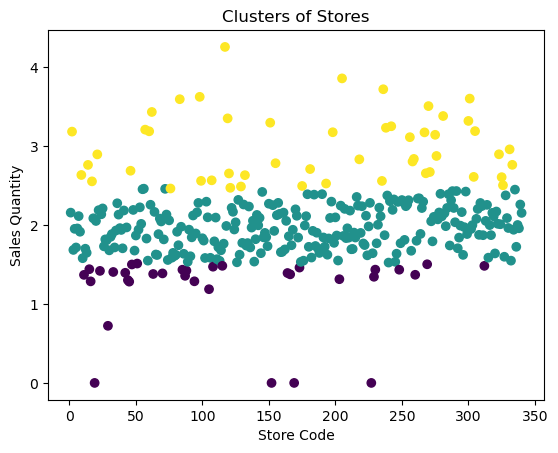

In [57]:
plt.scatter(average_sales_per_product['ProductCode'], average_sales_per_product['SalesQuantity'], c=product_clusters.cat.codes, label='Product Clusters')
plt.xlabel('Product Code')
plt.ylabel('Sales Quantity')
plt.title('Clusters of Products')
plt.show()

plt.scatter(average_sales_per_store['StoreCode'], average_sales_per_store['SalesQuantity'], c=store_clusters.cat.codes, label='Store Clusters')
plt.xlabel('Store Code')
plt.ylabel('Sales Quantity')
plt.title('Clusters of Stores')
plt.show()


# c & f

Product number 219 stands out with the largest average sale increase during promotion times, evident from its tall spike in the plot. Moreover, products numbered between 210 and 220 show notably higher increases compared to others. The impact of promotion is most pronounced on slow-moving items, although fast items also experience a significant boost. This observation aligns with the expectation that promotion would increase sales for items with both high and low demand. Fast-moving items naturally see a sales increase due to their existing high demand, while slow-moving items benefit from the increased demand generated by promotions, as they often have ample supply in stores. Conversely, medium-moving items exhibit the smallest increase, likely due to their position at the negative optimum of supply and demand.


Product with biggest sale increase is 219 with increase of 4.39896962976049 average sales during promotion times


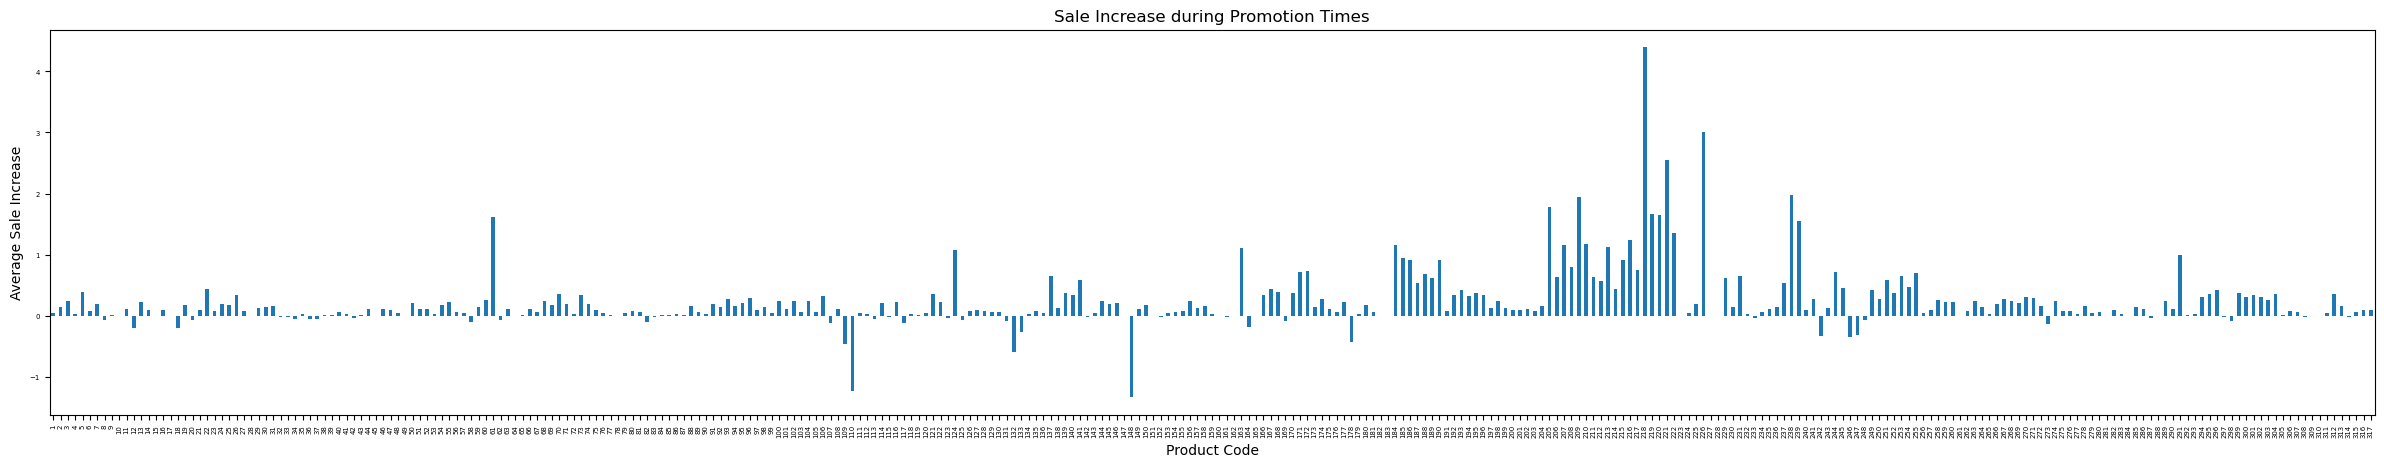

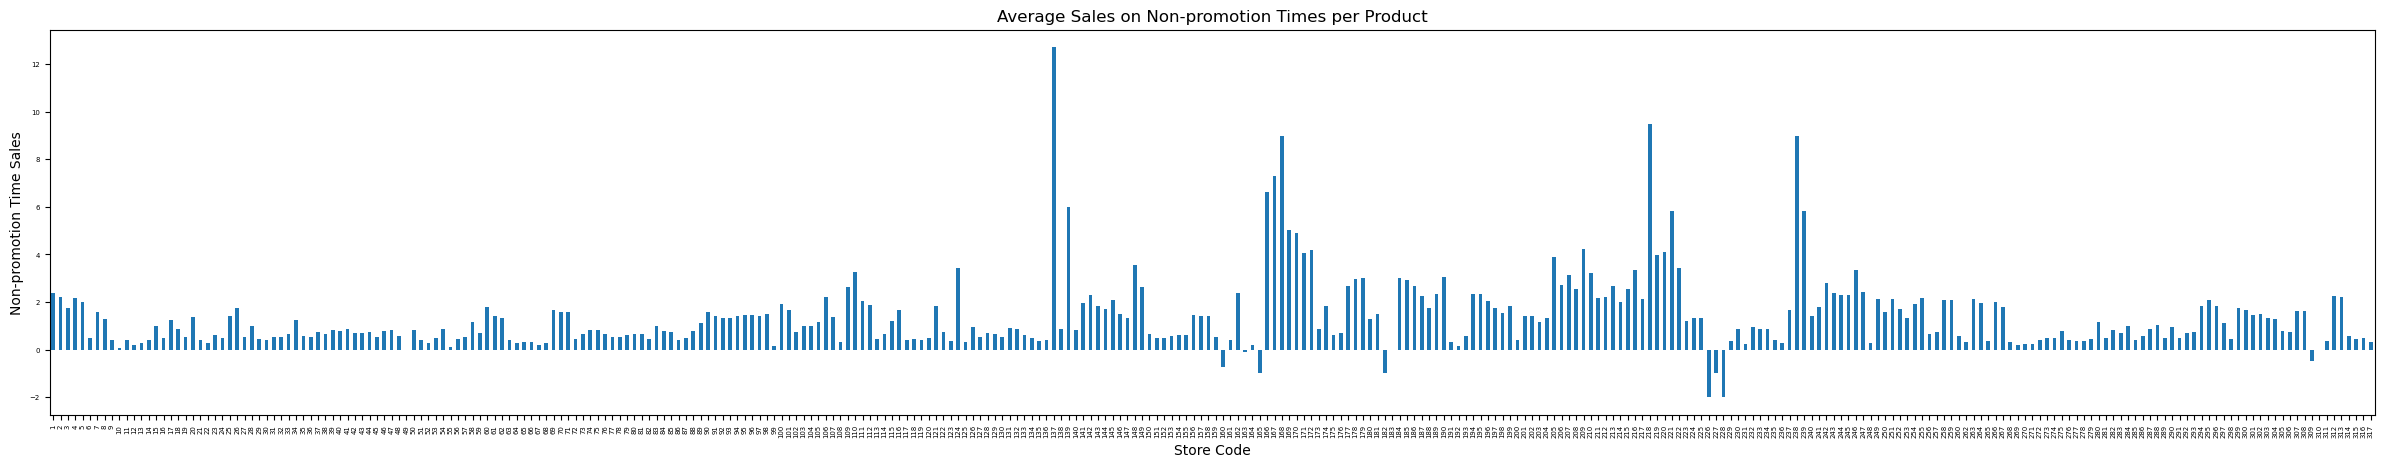

Average sales increase for Fast items during promotion times: 0.6169330980174137
Average sales increase for Medium items during promotion times: 0.12748019141540368
Average sales increase for Slow items during promotion times: 0.7939336466074639


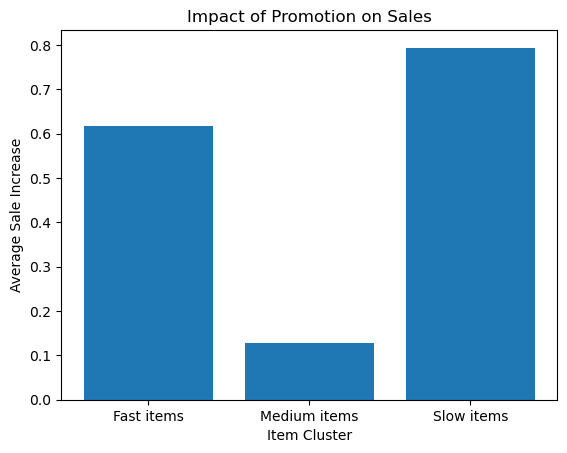

In [58]:
sales_increase = sales_data_promotion[sales_data_promotion["Promotion"]].groupby("ProductCode")["SalesQuantity"].mean() - sales_data_promotion[~sales_data_promotion["Promotion"]].groupby("ProductCode")["SalesQuantity"].mean()
product_with_biggest_increase = sales_increase.idxmax()
print("Product with biggest sale increase is " + str(product_with_biggest_increase + 1) +  " with increase of " + str(sales_increase.loc[product_with_biggest_increase]) + " average sales during promotion times")

sales_increase.plot(kind='bar',figsize=(30,5), fontsize = 5)
plt.xlabel('Product Code')
plt.ylabel('Average Sale Increase')
plt.title('Sale Increase during Promotion Times')
plt.xticks(rotation=90)
plt.show()


sales_data_promotion[~sales_data_promotion["Promotion"]].groupby("ProductCode")["SalesQuantity"].mean().plot(kind='bar',figsize=(30,5), fontsize = 5)
plt.xlabel('Store Code')
plt.ylabel('Non-promotion Time Sales')
plt.title('Average Sales on Non-promotion Times per Product')
plt.xticks(rotation=90)
plt.show()

fast_items = average_sales_per_product[average_sales_per_product['Cluster'] == 'Fast items']['ProductCode']
medium_items = average_sales_per_product[average_sales_per_product['Cluster'] == 'Medium items']['ProductCode']
slow_items = average_sales_per_product[average_sales_per_product['Cluster'] == 'Slow items']['ProductCode']

fast_items_avg_increase = sales_increase.loc[fast_items].mean()
medium_items_avg_increase = sales_increase.loc[medium_items].mean()
slow_items_avg_increase = sales_increase.loc[slow_items].mean()


print("Average sales increase for Fast items during promotion times:", fast_items_avg_increase)
print("Average sales increase for Medium items during promotion times:", medium_items_avg_increase)
print("Average sales increase for Slow items during promotion times:", slow_items_avg_increase)

plt.bar(['Fast items', 'Medium items','Slow items'], [fast_items_avg_increase, medium_items_avg_increase, slow_items_avg_increase])
plt.xlabel('Item Cluster')
plt.ylabel('Average Sale Increase')
plt.title('Impact of Promotion on Sales')
plt.show()


# d & g

The effect of promotion on stores reveals an interesting pattern. Store 93 exhibits the highest increase in sales during promotion times, followed by store 226, which also demonstrates good performance. However, store 130 experiences a significant decrease in sales during promotion periods. Furthermore, the magnitude of sales increase decreases with respect to the clusters of stores. Fast-moving stores show the highest increase, followed by medium-moving stores, while slow-moving stores exhibit the lowest increase. This suggests a linear connection between the promotion effect and store performance, which is intuitive. The best-performing stores likely have the highest location advantage and accessibility. Therefore, during promotions, people seeking to benefit from the promotions tend to visit these locations.


Store with biggest sale increase is 93 with increase of 2.914636603956992 average sales during promotion times:


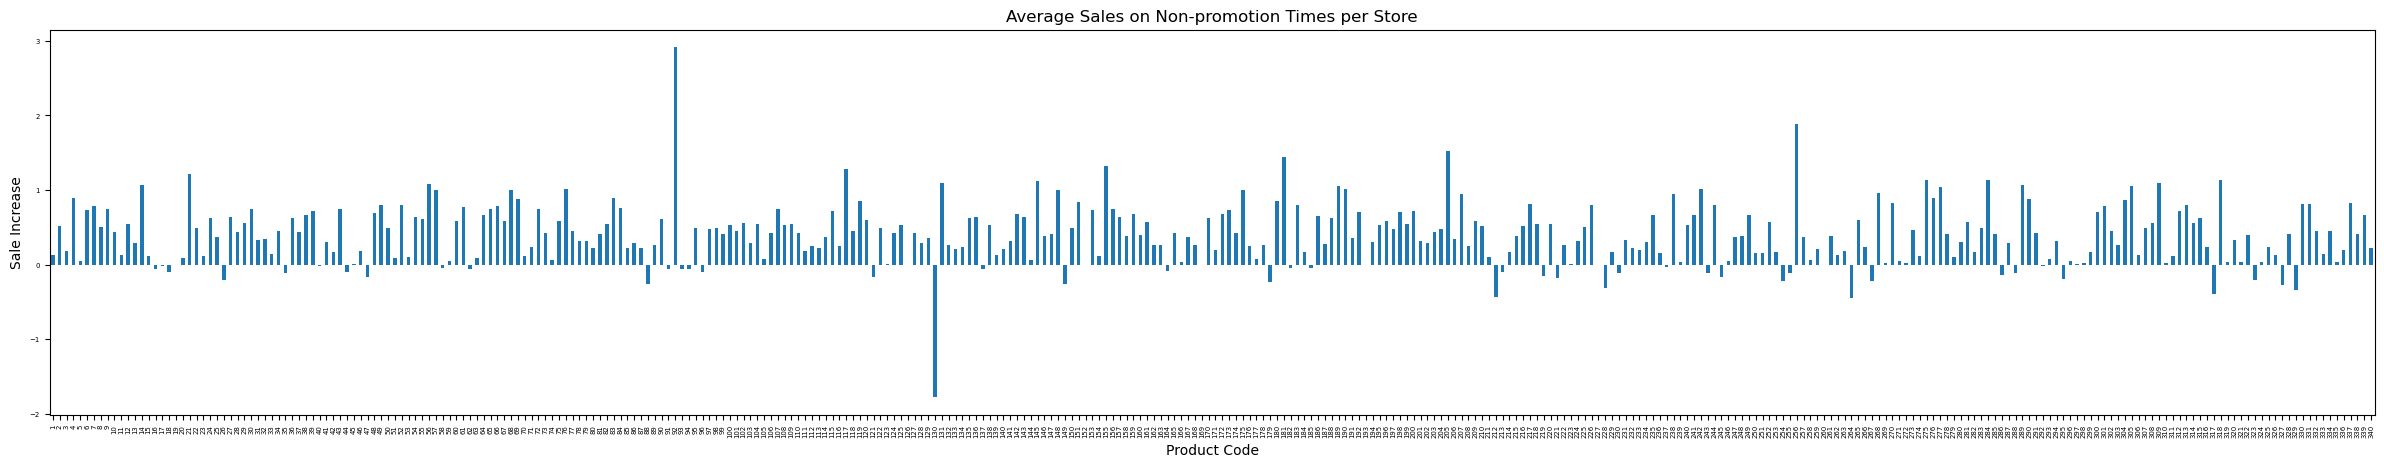

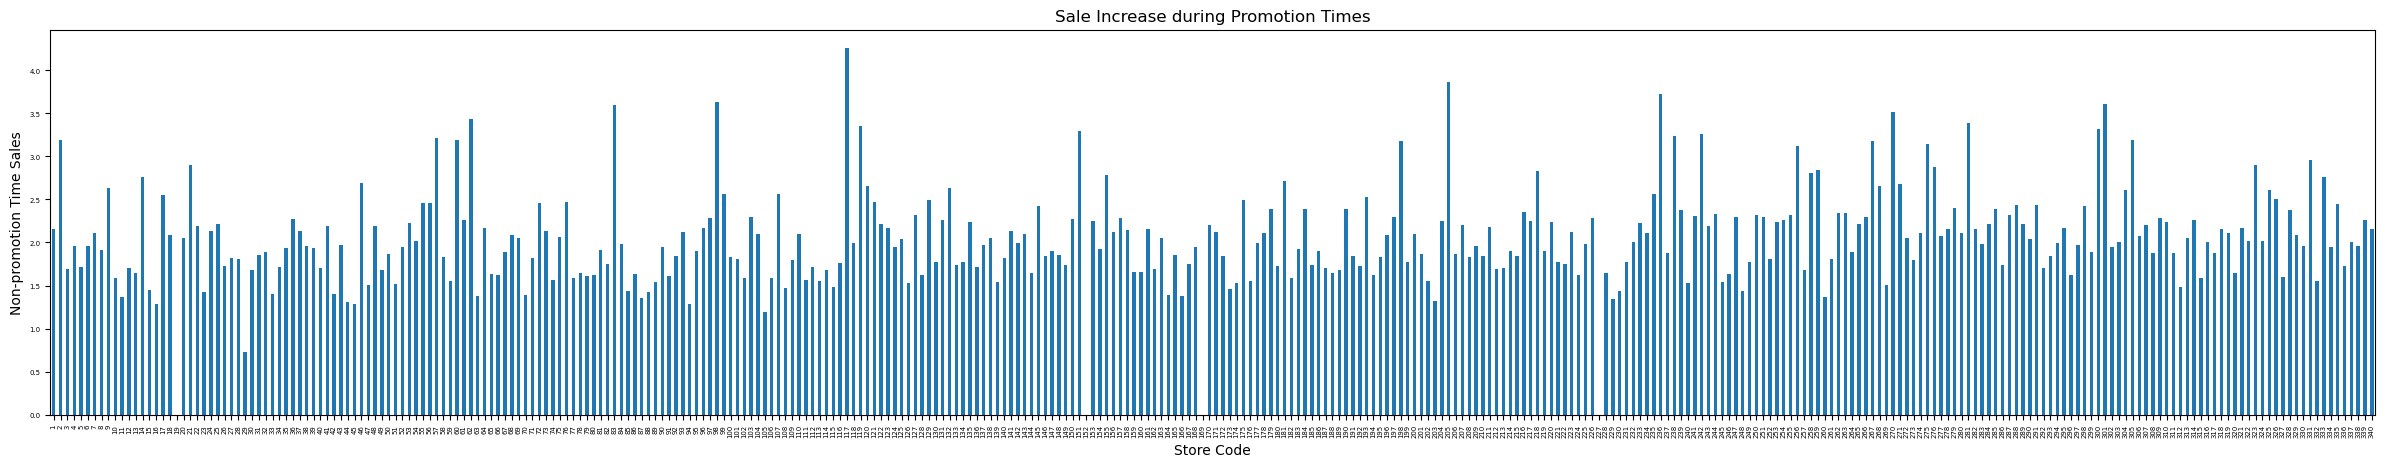

Average sales increase for Fast stores during promotion times: 0.6467298682120151
Average sales increase for Medium stores during promotion times: 0.3755920551747151
Average sales increase for Slow stores during promotion times: 0.1634203372974322


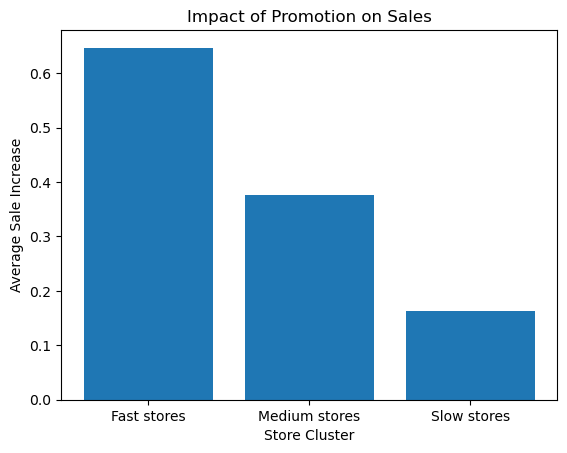

In [59]:
sales_increase = sales_data_promotion[sales_data_promotion["Promotion"]].groupby("StoreCode")["SalesQuantity"].mean() - sales_data_promotion[~sales_data_promotion["Promotion"]].groupby("StoreCode")["SalesQuantity"].mean()
product_with_biggest_increase = sales_increase.idxmax()
print("Store with biggest sale increase is " + str(product_with_biggest_increase + 1) +  " with increase of " + str(sales_increase.loc[product_with_biggest_increase]) + " average sales during promotion times:")

sales_increase.plot(kind='bar',figsize=(30,5), fontsize = 5)
plt.xlabel('Product Code')
plt.ylabel('Sale Increase')
plt.title('Average Sales on Non-promotion Times per Store')
plt.xticks(rotation=90)
plt.show()


sales_data_promotion[~sales_data_promotion["Promotion"]].groupby("StoreCode")["SalesQuantity"].mean().plot(kind='bar',figsize=(30,5), fontsize = 5)
plt.xlabel('Store Code')
plt.ylabel('Non-promotion Time Sales')
plt.title('Sale Increase during Promotion Times')
plt.xticks(rotation=90)
plt.show()

fast_stores = average_sales_per_store[average_sales_per_store['Cluster'] == 'Fast stores']['StoreCode']
medium_stores = average_sales_per_store[average_sales_per_store['Cluster'] == 'Medium stores']['StoreCode']
slow_stores = average_sales_per_store[average_sales_per_store['Cluster'] == 'Slow stores']['StoreCode']

fast_stores_avg_increase = sales_increase.loc[fast_stores].mean()
medium_stores_avg_increase = sales_increase.loc[medium_stores].mean()
slow_stores_avg_increase = sales_increase.loc[slow_stores].mean()


print("Average sales increase for Fast stores during promotion times:", fast_stores_avg_increase)
print("Average sales increase for Medium stores during promotion times:", medium_stores_avg_increase)
print("Average sales increase for Slow stores during promotion times:", slow_stores_avg_increase)

plt.bar(['Fast stores', 'Medium stores','Slow stores'], [fast_stores_avg_increase, medium_stores_avg_increase, slow_stores_avg_increase])
plt.xlabel('Store Cluster')
plt.ylabel('Average Sale Increase')
plt.title('Impact of Promotion on Sales')
plt.show()

# Evaluation and Anaysis of the Model

## Data Exploation of New Data

This time, we will use data that starts when the initial data ends. By doing so, we can evaluate our model with this dataset that was not used in training or validation, making it our test dataset. But first, we will create the same plot showing total sales per day, with yellow shaded regions indicating the promotion dates. A crucial point that can be observed from the graph and confirmed using a search is that previous promotion dates started at the beginning of the week, when sales are at their lowest, and peaked in the middle of the promotion. However, this promotion starts at the end of the week, on Friday, when sales are at their peak. Consequently, sales drop initially and then rise again during the promotion period.


               Date  StoreCode  ProductCode  SalesQuantity
1028116  2016-01-01        340          247              5
1028117  2016-01-01        340          264              1
1028118  2016-01-01        340          292              1
1028119  2016-01-01        340          305              1
1028120  2016-01-01        340          313              1


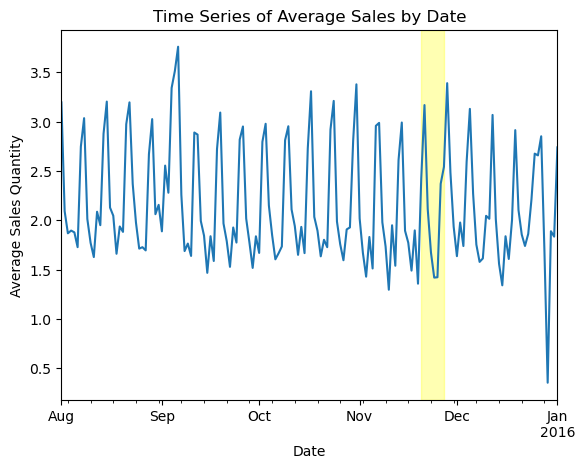

In [60]:
sales_data_test = pd.read_csv("Assignment4.1b.csv")
print(sales_data_test.tail())
sales_data_test['Date'] = pd.to_datetime(sales_data_test['Date'])

sales_data_test.groupby('Date')['SalesQuantity'].mean().plot()

for index, row in promotion_data.iterrows():
    plt.axvspan(row['StartDate'], row['EndDate'], alpha=0.3, color='yellow')

plt.xlabel('Date')
plt.ylabel('Average Sales Quantity')
plt.title('Time Series of Average Sales by Date')
plt.show()

## Model Evaluation on New Data

The code in the provided cell performs several tasks related to regression analysis and error analysis.

1. **Mean Squared Error Calculation**: The code calculates and prints the mean squared error (MSE) between the predicted values (`regressor.predict(X)`) and the actual values (`y`). The MSE is a measure of how well the regression model fits the data, with lower values indicating better fit.

2. **Visualization of Actual vs. Predicted Values**: The code plots the actual values (`y`) and the predicted values (`regressor.predict(X)`) on a line graph. This visualization aids in comparing the predicted values with the actual values and visually assessing the performance of the regression model. It helps understand if the model predicts randomly, predicts just the average, or makes good predictions that have a similar distribution to the real values.

3. **Identification of Inputs with Highest and Lowest Errors**: The code finds the inputs that have the highest and lowest error. This helps understand the pros and cons of the model and feature engineering.

4. **Feature-wise Error Analysis**: The code performs feature-wise error analysis by grouping the dataset (`X_nohe`) with the errors (`errors`) based on different features such as DayOfWeek, WeekInMonth, Promotion, StoreCode, and ProductCode. For each feature, it calculates the average error per group. Additionally, it further groups the average error per feature and finds the maximum average error value (`max_value`) and its corresponding index (`max_index`) for each feature.

Overall, the code provides insights into the performance of the regression model by calculating the MSE, visualizing the prediction vs. actual values, identifying inputs with the smallest and highest errors, and performing feature-wise error analysis.


In [61]:
non_exist = set(sales_data['ProductCode']) - set(sales_data_test['ProductCode'])
for product in non_exist:
    print("Product numbered " + str(product) + "is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformation.")
    sales_data_test = pd.concat([sales_data_test, pd.DataFrame.from_records([{'Date': sales_data.loc[0]["Date"], 'StoreCode': 1, 'ProductCode': product, 'SalesQuantity': 0}])],ignore_index=True)
non_exist = set(sales_data['StoreCode']) - set(sales_data_test['StoreCode'])
for store in non_exist:
    print("Store numbered " + str(store) + "is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformation.")
    sales_data_test = pd.concat([sales_data_test, pd.DataFrame.from_records([{'Date': sales_data.loc[0]["Date"], 'StoreCode': store, 'ProductCode': 1, 'SalesQuantity': 0}])],ignore_index=True)

sales_data_test['Date'] = pd.to_datetime(sales_data_test['Date'])
X, y = prepare_data(sales_data_test, promotion_data.loc[5].to_frame().T)

Product numbered 226is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformation.
Product numbered 227is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformation.
Product numbered 228is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformation.
Product numbered 229is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformation.
Product numbered 261is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformation.
Product numbered 281is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformation.
Product numbered 8is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformation.
Product numbered 73is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformation.
Product numbered 291is not exist in new dataset, adding a dummy row to fix errors caused by OHE transformat

Final Regressor Test MSE: 17.231320828374272


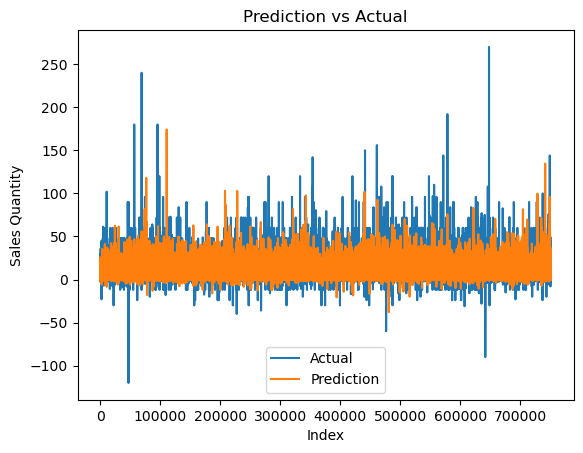

Input with the smallest error:
DayOfWeek          0
WeekInMonth        1
Promotion      False
StoreCode          1
ProductCode      247
Name: 107, dtype: object
Error: 0.0


Input with the highest error:
DayOfWeek          6
WeekInMonth        0
Promotion      False
StoreCode        131
ProductCode      238
Name: 647742, dtype: object
Error: 262.77
Index of max value: 5
Max value: 2.268456148425434


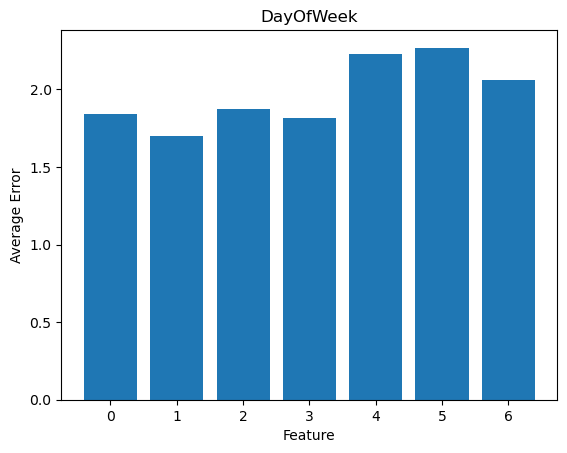

Index of max value: 5
Max value: 2.139888075502879


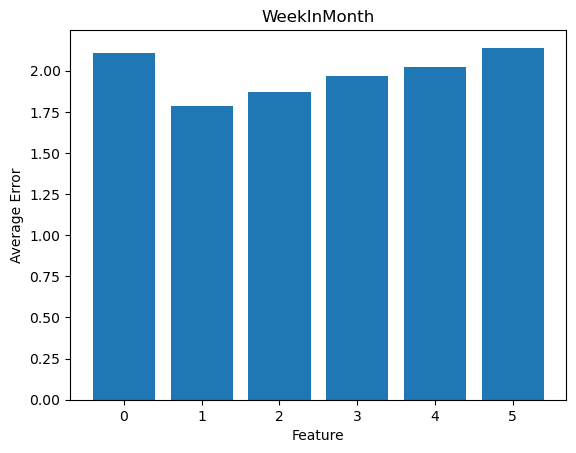

Index of max value: True
Max value: 2.2465916526476004


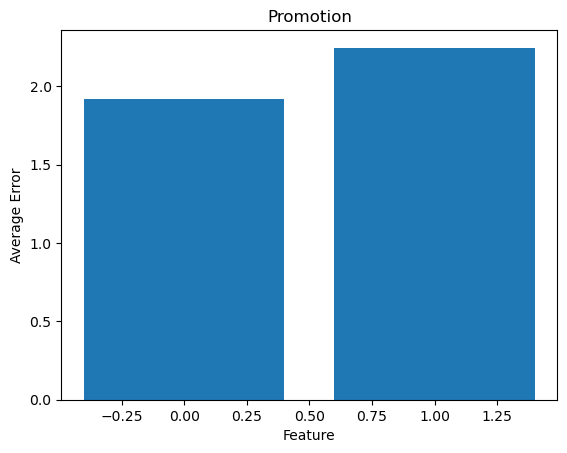

Index of max value: 152
Max value: 8.535


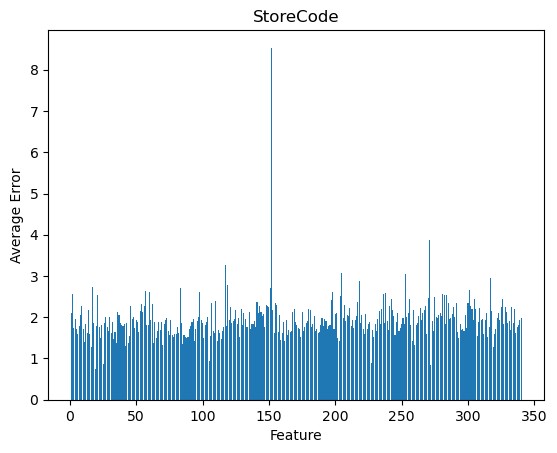

Index of max value: 137
Max value: 21.765623273480664


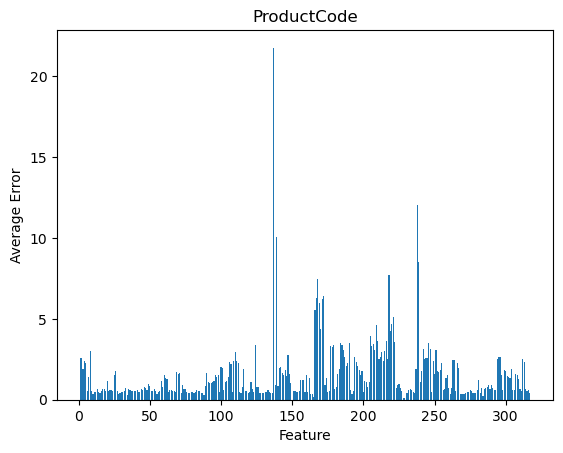

In [62]:
print("Final Regressor Test MSE:", mean_squared_error(y, regressor.predict(X)))

# Plot the prediction and y values
plt.plot(y, label='Actual')
plt.plot(regressor.predict(X), label='Prediction',)
plt.xlabel('Index')
plt.ylabel('Sales Quantity')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()


y_pred = regressor.predict(X)

errors = (y - y_pred).abs()


smallest_error_index = errors.idxmin()
highest_error_index = errors.idxmax()

smallest_error_input = X.iloc[smallest_error_index]
highest_error_input = X.iloc[highest_error_index]


]print("Input with the smallest error:")
print(smallest_error_input)
print("Error: " + str(errors.iloc[smallest_error_index]))
print("\n")
print("Input with the highest error:")
print(highest_error_input)
print("Error: " + str(errors.iloc[highest_error_index]))



X_nohe, _ = prepare_data(sales_data_test, promotion_data.loc[5].to_frame().T, False)
average_error_per_feature = pd.concat([X_nohe,errors],axis = 1)
average_error_per_feature = average_error_per_feature.groupby(['DayOfWeek', 'WeekInMonth', 'Promotion', 'StoreCode', 'ProductCode']).mean()
for i in ['DayOfWeek', 'WeekInMonth', 'Promotion', 'StoreCode', 'ProductCode']:
    temp = average_error_per_feature.groupby(i).mean()
    max_index = temp['SalesQuantity'].idxmax()
    max_value = temp.loc[max_index, 'SalesQuantity']
    print("Index of max value:", max_index)
    print("Max value:", max_value)
    plt.bar(temp.index, temp['SalesQuantity'])
    plt.xlabel('Feature')
    plt.ylabel('Average Error')
    plt.title(i)
    plt.show()


Firstly, our test error is remarkably low, indicating that our model performs well. The average error per feature reveals that the error rate is higher on promotion dates, supporting our hypothesis. The distribution of true values and predicted values are very similar, indicating that our model isn't simply predicting random or average values but is making knowledge-based predictions. However, the error for certain unique stores and several products is much higher, which warrants further investigation. Another important remart is that model does not perform well predicting negative sales (returns).


# Model Evaluation and Data Exploartion with Promotion 5

First, we do the same visualiation to see the sales and promotion dates. The most important point here is, it is possible for two promotions to happen simulatniously. This is agains our assumption while designing our model, which introduces bias. Another crucial point is two promotions do not have the same effect. The promotions 1-4 increases the sales clearly oberable with spikes, however promotion 5 seems to have a more aggregate effect of increaasing sales.

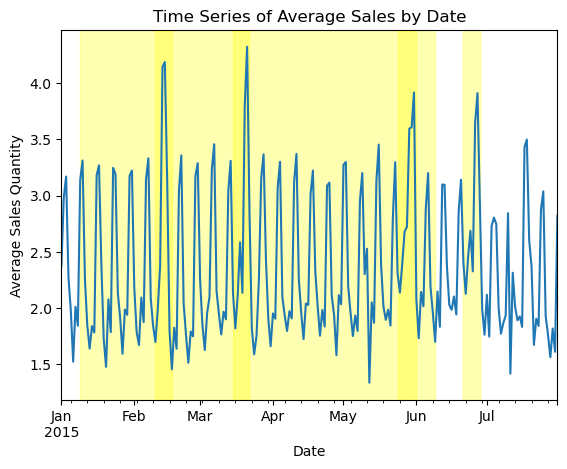

In [63]:
sales_data.groupby('Date')['SalesQuantity'].mean().plot()

for index, row in promotion_data[:5].iterrows():
    plt.axvspan(row['StartDate'], row['EndDate'], alpha=0.3, color='yellow')

plt.xlabel('Date')
plt.ylabel('Average Sales Quantity')
plt.title('Time Series of Average Sales by Date')
plt.show()


Now, we will assume that Promotion 5 is the only active promotion and check the performance of and consider the sales during this peroid.

Final Regressor Promotion 5 MSE: 1.9319026012418616


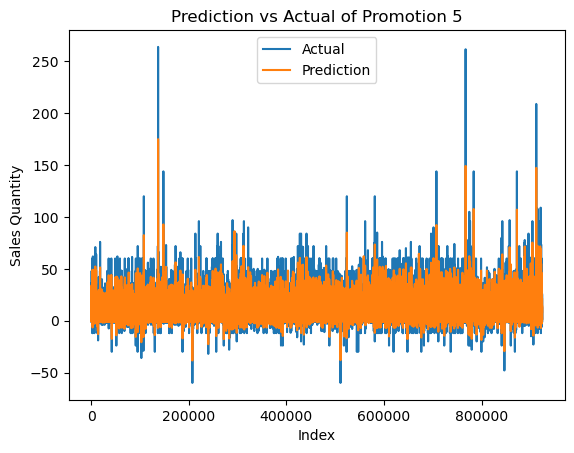

In [64]:
X, y = prepare_data(sales_data[sales_data['Date'].between(promotion_data.loc[4]["StartDate"], promotion_data.loc[4]["EndDate"])], promotion_data.loc[4].to_frame().T)

print("Final Regressor Promotion 5 MSE:", mean_squared_error(y, regressor.predict(X)))

plt.plot(y, label='Actual')
plt.plot(regressor.predict(X), label='Prediction',)
plt.xlabel('Index')
plt.ylabel('Sales Quantity')
plt.title('Prediction vs Actual of Promotion 5')
plt.legend()
plt.show()


The MSE is very low, which is expected since we used trainig data, with a small change, to evaluate the model. It is clear that this is a very biased method to evalue, so we need a new data and a setting with a promotion similar to 5. 

# Conclusion

We performed data analytics and developed a model to forecast sales for several shops for different items and the effect of promotion on these sales. While our model design depends on discrete features, it is possible to use a model more suited for time-series analysis such as ARIMA, especially for larger datasets.

Like every Machine Learning model, our developed model and feature engineering depend on some assumptions which introduce biases. First of all, we assumed that there is no regressive behavior in our data so we used a discrete model. Also, we assumed that concurrent promotions are not possible and all promotions are of the same type. Finally, our analysis with new data (test) clearly showed that the start date of the promotion is another important feature. So for future work, these points need to be pointed out to improve the model.

The evaluation of the model, especially with Promotion 5, was problematic due to using training data. In future work, this is the most important issue to be addressed to understand and improve the model.

On the analysis side, the client can take actions to increase their profit using the analytics we showed. First of all, it is possible to find an optimal demand-supply point by shifting particular products to particular stores. It is also important to understand the different effects of promotions on store and item clusters. While the promotion and sale increase have a linear relationship with store clusters, it needs more attention and analysis for the item promotion relationship.

For future work, it will be useful to have datasets that provide more contextual information about the products and the stores, such as locations, item types, etc. Additionally, having more information about dates such as holidays or extraordinary events such as pandemics or crises can enhance the performance of the model.
